In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import gzip
import tensorflow as tf
import glob
import math
import skimage
from matplotlib.patches import Rectangle
import json

In [5]:
tf.enable_eager_execution()

In [6]:
from softlearning.replay_pools.utils import get_replay_pool_from_variant

def get_grid_vals(env, n_samples):
    n_samples = 50
    obs_space = env.observation_space['state_observation']
    xs = np.linspace(obs_space.low[0], obs_space.high[0], n_samples)
    ys = np.linspace(obs_space.low[1], obs_space.high[1], n_samples)
    xys = np.meshgrid(xs, ys)
    return np.array(xys).transpose(1, 2, 0).reshape((n_samples * n_samples, 2)), xys

def get_replay_pool(checkpoint, checkpoint_dir):
    from softlearning.replay_pools.utils import get_replay_pool_from_variant

    variant = checkpoint['variant']
    train_env = checkpoint['training_environment']
    replay_pool = get_replay_pool_from_variant(variant, train_env)

    replay_pool_path = os.path.join(checkpoint_dir, 'replay_pool.pkl')
    replay_pool.load_experience(replay_pool_path)
    return replay_pool

def plot_trajectories(checkpoint, checkpoint_dir, num_trajectories=10):
    replay_pool = get_replay_pool(checkpoint, checkpoint_dir)
    trajectories = replay_pool.last_n_batch(100 * num_trajectories)['observations']['state_observation'] \
                    .reshape(num_trajectories, 100, -1)
    for i in range(num_trajectories):
        plt.plot(trajectories[i,:,0], trajectories[i,:,1], color='w', linewidth=1)

## Specify the Experiment Directory

In [363]:
common_dir = '/Users/kevintli/rail/data/ray_results'
universe = 'gym'
domain = 'Point2D'
task = 'Maze-v0'

In [364]:
base_path = os.path.join(common_dir, universe, domain, task)
exps = sorted(list(glob.iglob(os.path.join(base_path, '*'))))
for i, exp in enumerate(exps):
    print(f'{i} \t {exp.replace(base_path, "")}')
    
exp_choice = int(input('\n Which experiment do you want to analyze? (ENTER A NUMBER) \t'))

exp_path = exps[exp_choice]
print('\n')
seeds = sorted(list(glob.iglob(os.path.join(exp_path, '*'))))
seeds = [seed for seed in seeds if os.path.isdir(seed)]
for i, seed in enumerate(seeds):
    print(f'{i} \t {seed.replace(exp_path, "")}')
    
# TODO: Extend to analyzing all seeds
seed_choice = int(input('\n Which seed do you want to analyze? (ENTER A NUMBER) \t'))

seed_path = seeds[seed_choice]

print('PATH:\n', seed_path)

0 	 /2020-05-27T16-46-37-ddl_maze
1 	 /2020-05-27T18-08-07-ddl_maze_count
2 	 /2020-05-28T15-34-01-dynamics_aware_vice

 Which experiment do you want to analyze? (ENTER A NUMBER) 	2


0 	 /54b849c0-algorithm=DynamicsAwareEmbeddingVICE-seed=2429_2020-05-28_15-34-02gajwlkto
1 	 /54b8f44c-algorithm=DynamicsAwareEmbeddingVICE-seed=1765_2020-05-28_15-34-02da0k1l3a
2 	 /54b97994-algorithm=DynamicsAwareEmbeddingVICE-seed=1773_2020-05-28_15-34-021ipxtyo0
3 	 /54b9f2ca-algorithm=DynamicsAwareEmbeddingVICE-seed=22_2020-05-28_15-34-033obu0i5l
4 	 /54c18c24-algorithm=DynamicsAwareEmbeddingVICE-seed=30_2020-05-28_15-34-03gvi_bqa2
5 	 /54c214b4-algorithm=DynamicsAwareEmbeddingVICE-seed=8587_2020-05-28_15-34-03hkpvt193
6 	 /54c9950e-algorithm=DynamicsAwareEmbeddingVICE-seed=6415_2020-05-28_15-34-03aeb2o58_
7 	 /54d5da62-algorithm=DynamicsAwareEmbeddingVICE-seed=3727_2020-05-28_15-34-03v1lv5fgl

 Which seed do you want to analyze? (ENTER A NUMBER) 	0
PATH:
 /Users/kevintli/rail/data/ray_results/gym/Po

In [365]:
import json

# Print hyperparameters

with open(os.path.join(seed_path, 'params.pkl'), 'rb') as f:
    params = pickle.load(f)

print(json.dumps(params, indent=4))
hyperparams = {
#     'use_count_reward': params['environment_params']['training']['kwargs'].get('use_count_reward', False),
    'positive_on_first_occurrence': params['algorithm_params']['kwargs']['positive_on_first_occurence'],
    'weight_decay': bool(params['reward_classifier_params']['kwargs']['observation_preprocessors_params']['state_observation']['kwargs']['kernel_regularizer'])
}
for name, value in hyperparams.items():
    print(f"{name}: {value}")

{
    "git_sha": "842c586cbd7fc989e9fbf0cbad49ba8742915edf master",
    "num_goals": 2,
    "environment_params": {
        "training": {
            "domain": "Point2D",
            "task": "Maze-v0",
            "universe": "gym",
            "kwargs": {
                "action_scale": 0.5,
                "images_are_rgb": true,
                "reward_type": "none",
                "use_count_reward": false,
                "n_bins": 100,
                "wall_shape": "medium-maze",
                "init_pos_range": [
                    [
                        -3,
                        -3
                    ],
                    [
                        -3,
                        -3
                    ]
                ],
                "target_pos_range": [
                    [
                        3,
                        3
                    ],
                    [
                        3,
                        3
                    ]
                ],
  

## Specify the Checkpoint

In [366]:
checkpoint_to_analyze = 200
checkpoint_dir = os.path.join(seed_path, f'checkpoint_{checkpoint_to_analyze}')

In [367]:
with open(os.path.join(seed_path, f'{checkpoint_dir}/checkpoint.pkl'), 'rb') as f:
    checkpoint = pickle.load(f)

W0529 03:43:23.409446 140736058082176 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0529 03:43:23.483641 140736058082176 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


## Load Reward Classifier

In [368]:
print(checkpoint.keys())

dict_keys(['variant', 'training_environment', 'evaluation_environment', 'algorithm', 'policy_weights', 'rnd_networks', 'reward_classifier', 'distance_estimator'])


In [369]:
reward_clf = checkpoint['reward_classifier']

In [370]:
train_env = checkpoint['training_environment']

In [371]:
target_pos = train_env.unwrapped._get_obs()['state_desired_goal']

In [372]:
n_bins = train_env.n_bins + 1

for i in range(n_bins):
    for j in range(n_bins):
        obs = np.eye(n_bins)[np.array([i, j])].flatten()

In [373]:
n_samples = 50
obs_space = train_env.unwrapped.observation_space['state_observation']
xs = np.linspace(obs_space.low[0], obs_space.high[0], n_samples)
ys = np.linspace(obs_space.low[1], obs_space.high[1], n_samples)

xys = np.meshgrid(xs, ys)

In [374]:
grid_vals = np.array(xys).transpose(1, 2, 0).reshape((n_samples * n_samples, 2))
# grid_vals = np.array([np.eye(n_bins)[train_env.unwrapped._discretize_observation(grid_val)].flatten() for grid_val in grid_vals])

In [375]:
grid_vals.shape

(2500, 2)

In [376]:
rewards = reward_clf.predict(grid_vals)

In [377]:
reward_clf.summary()

Model: "picklable_model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
state_observation (InputLaye [(None, 2)]               0         
_________________________________________________________________
embedding_fn (PicklableModel (None, 2)                 67074     
_________________________________________________________________
feedforward_reward_classifie (None, 1)                 66817     
Total params: 133,891
Trainable params: 133,891
Non-trainable params: 0
_________________________________________________________________


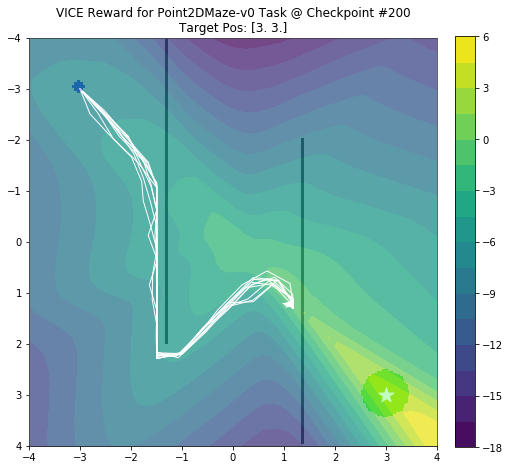

In [378]:
plt.figure(figsize=(8, 8))
from matplotlib.patches import Rectangle

plt.imshow(train_env.render('rgb_array', width=256, height=256),
           extent=(-4, 4, -4, 4), origin='lower', alpha=0.25, zorder=3)

plt.gca().invert_yaxis()
plt.contourf(xys[0], xys[1], rewards.reshape(xys[0].shape), levels=20)
plt.colorbar(fraction=0.046, pad=0.04)
plot_trajectories(checkpoint, checkpoint_dir)

if task == 'BoxWall-v1':
    currentAxis = plt.gca()
    currentAxis.add_patch(Rectangle((-2, -2), 4, 4,
                          alpha=1, fill=None, linewidth=4))

plt.scatter(*target_pos, marker='*', s=250, color='white')
plt.title(f'VICE Reward for {domain + task} Task @ Checkpoint #{checkpoint_to_analyze}\n'
          + f'Target Pos: {target_pos}')
plt.show()

## Plot All Checkpoints at Once

In [379]:
def plot_vice_reward(clf, train_env, n_samples=50):
    obs_space = train_env.observation_space['state_observation']
    xs = np.linspace(obs_space.low[0], obs_space.high[0], n_samples)
    ys = np.linspace(obs_space.low[1], obs_space.high[1], n_samples)

    xys = np.meshgrid(xs, ys)
    grid_vals = np.array(xys).transpose(1, 2, 0).reshape((n_samples * n_samples, 2))
    
    rewards = clf.predict(grid_vals)
    plt.gca().invert_yaxis()
    plt.contourf(xys[0], xys[1], rewards.reshape(xys[0].shape), levels=300)
    plt.colorbar(fraction=0.046, pad=0.04)
    target_pos = train_env.unwrapped._get_obs()['state_desired_goal']

    if task == 'BoxWall-v1':
        currentAxis = plt.gca()
        currentAxis.add_patch(Rectangle((-2, -2), 4, 4,
                              alpha=1, fill=None, linewidth=4))

    plt.scatter(*target_pos, marker='*', s=250, color='white')

In [380]:
def plot_grid(imgs, labels=None):
    n_images = len(imgs)
    n_columns = np.sqrt(n_images)
    n_rows = np.ceil(n_images / n_columns) + 1
    plt.figure(figsize=(5 * n_columns, 5 * n_rows))
    for i, img in enumerate(imgs):
        plt.subplot(n_rows, n_columns, i+1)
        plt.axis('off')
        plt.imshow(img)
        if labels is not None:
            plt.title(labels[i], fontsize=20)
    plt.show()

In [381]:
checkpoint_paths = list(glob.iglob(os.path.join(seed_path, 'checkpoint_*')))
# Sort by the checkpoint number at the end
checkpoint_paths = sorted(checkpoint_paths, key=lambda s: int(s.split("_")[-1]))

W0529 03:44:47.991384 140736058082176 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0529 03:44:48.058749 140736058082176 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0529 03:44:48.619436 140736058082176 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0529 03:44:48.709054 140736058082176 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0529 03:44:49.257164 140736058082176 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0529 03:44:49.335743 140736058082176 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0529 03:44:49.932614 140736058082176 hdf5_format.py:171] No training 

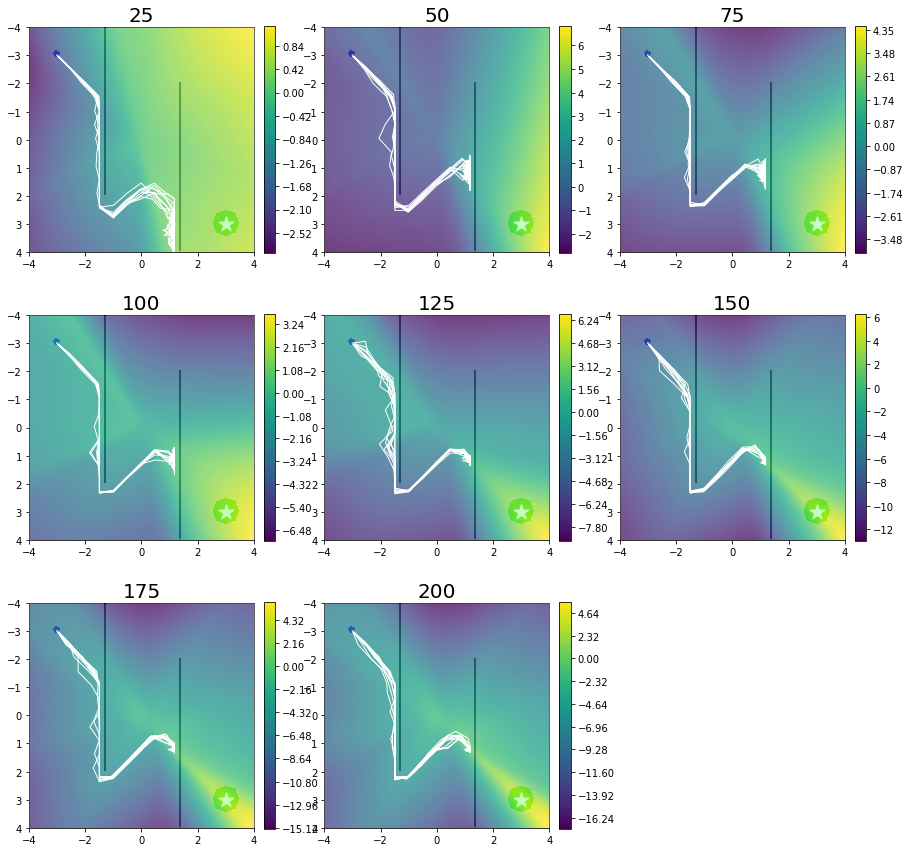

In [382]:
n_plots = len(checkpoint_paths)
n_columns = int(np.sqrt(n_plots) + 1)
n_rows = np.ceil(n_plots / n_columns)
plt.figure(figsize=(5 * n_columns, 5 * n_rows))

for i, path in enumerate(checkpoint_paths):
    with open(os.path.join(path, 'checkpoint.pkl'), 'rb') as f:
        checkpoint = pickle.load(f)
    reward_clf = checkpoint['reward_classifier']
    train_env = checkpoint['training_environment']
    plt.subplot(n_rows, n_columns, i+1, aspect=1)
    plt.imshow(train_env.render('rgb_array', width=256, height=256),
           extent=(-4, 4, -4, 4), origin='lower', alpha=0.25, zorder=3)
    plot_vice_reward(reward_clf, train_env)
    plot_trajectories(checkpoint, path)
    plt.title(int(path.split("_")[-1]), fontsize=20)
    
plt.show()

## Plot Visitations

In [383]:
from softlearning.replay_pools.utils import get_replay_pool_from_variant

replay_pool = None
train_env = None

for i, path in enumerate(checkpoint_paths):
    if replay_pool is None:
        with open(os.path.join(path, 'checkpoint.pkl'), 'rb') as f:
            checkpoint = pickle.load(f)
        variant = checkpoint['variant']
        train_env = checkpoint['training_environment']
        replay_pool = get_replay_pool_from_variant(variant, train_env)
        
    replay_pool_path = os.path.join(path, 'replay_pool.pkl')
    replay_pool.load_experience(replay_pool_path)

W0529 03:45:00.313968 140736058082176 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0529 03:45:00.377720 140736058082176 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


In [384]:
non_zero_rows = replay_pool.data[('observations', 'state_observation')].any(axis=-1)

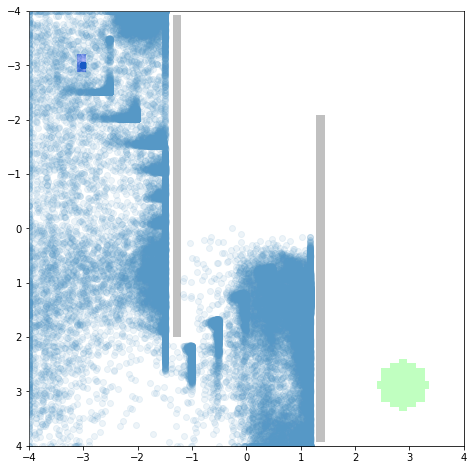

In [385]:
visitations = replay_pool.data[('observations', 'state_observation')][non_zero_rows]
plt.figure(figsize=(8, 8))
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.gca().invert_yaxis()
plt.imshow(train_env.render('rgb_array'),
           extent=(-4, 4, -4, 4),
           origin='lower',
           alpha=0.25,
           zorder=3,
           interpolation='nearest')

plt.scatter(visitations[:, 0], visitations[:, 1], alpha=0.1)

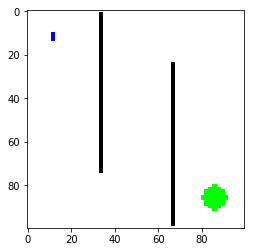

In [386]:
plt.imshow(train_env.render('rgb_array'))

## Plot Goal Examples

In [387]:
with open('/home/justinvyu/dev/vice/goal_classifier/pointmass_nowalls/bottom_middle/positives.pkl', 'rb') as f:
    data = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: '/home/justinvyu/dev/vice/goal_classifier/pointmass_nowalls/bottom_middle/positives.pkl'

In [ ]:
plt.figure(figsize=(8, 8))

plt.scatter(data['state_observation'][:,0], data['state_observation'][:,1], s=5)
plt.xlim([-4, 4])
plt.ylim([-4, 4])
plt.gca().invert_yaxis()

## Plot Embedding Distances

In [388]:
embedding_fn = checkpoint['distance_estimator']
train_env = checkpoint['training_environment']
target_pos = train_env.unwrapped._get_obs()['state_desired_goal']

n_samples = 50
grid_vals = get_grid_vals(train_env, n_samples)
goal_vals = np.repeat(target_pos[None], n_samples * n_samples, axis=0)
dists = np.linalg.norm(embedding_fn.predict(goal_vals) - embedding_fn.predict(grid_vals), axis=-1)

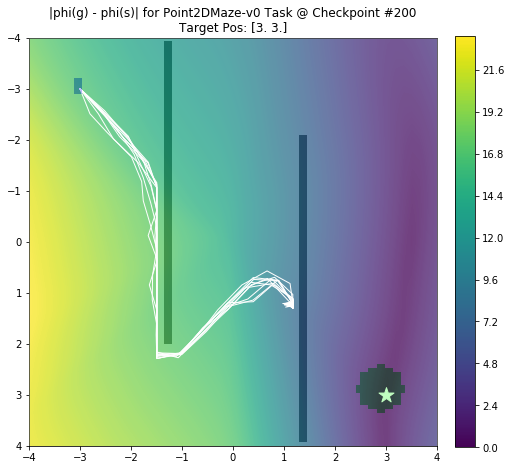

In [389]:
plt.figure(figsize=(8, 8))
from matplotlib.patches import Rectangle

plt.imshow(train_env.render('rgb_array', width=256, height=256),
           extent=(-4, 4, -4, 4), origin='lower', alpha=0.25, zorder=3)

plt.gca().invert_yaxis()
plt.contourf(xys[0], xys[1], dists.reshape(xys[0].shape), levels=300, zorder=1)
plt.colorbar(fraction=0.046, pad=0.04)

plot_trajectories(checkpoint, path)
    
plt.scatter(*target_pos, marker='*', s=250, color='white', zorder=2)

plt.title(f'|phi(g) - phi(s)| for {domain + task} Task @ Checkpoint #{checkpoint_to_analyze}\n'
          + f'Target Pos: {target_pos}')
plt.show()

## Plot Ground Truth Rewards

In [ ]:
feed_dict = {
    'state_achieved_goal': grid_vals,
    'state_desired_goal': np.full(grid_vals.shape, fill_value=2)
}
train_env.unwrapped.reward_type = 'sparse'
gtr = train_env.unwrapped.compute_rewards(None, feed_dict)
plt.figure(figsize=(8, 8))

from matplotlib.patches import Rectangle

plt.gca().invert_yaxis()

plt.contourf(xys[0], xys[1], gtr.reshape(xys[0].shape))
plt.colorbar(fraction=0.046, pad=0.04)

if task == 'BoxWall-v1':
    currentAxis = plt.gca()
    currentAxis.add_patch(Rectangle((-2, -2), 4, 4,
                          alpha=1, fill=None, linewidth=4))

plt.title(f'Ground Truth Reward for {domain + task} Task @ Checkpoint #{checkpoint_to_analyze}')

plt.scatter(*target_pos, marker='*', s=250, color='white')
plt.show()

## Qs Visualization

In [390]:
checkpoint_to_analyze = 200
checkpoint_dir = os.path.join(seed_path, f'checkpoint_{checkpoint_to_analyze}')

with open(os.path.join(checkpoint_dir, 'checkpoint.pkl'), 'rb') as f:
    checkpoint = pickle.load(f)

W0529 03:49:10.026025 140736058082176 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0529 03:49:10.087851 140736058082176 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


In [391]:
variant = checkpoint['variant']
env = checkpoint['training_environment']
target_pos = env.unwrapped._get_obs()['state_desired_goal']

In [392]:
from softlearning.value_functions.utils import get_Q_function_from_variant

In [393]:
Qs = get_Q_function_from_variant(variant, env)

In [394]:
for i, Q in enumerate(Qs):
    weights_path = os.path.join(checkpoint_dir, f'Qs_{i}')
    Q.load_weights(weights_path)

In [395]:
n_action_samples = 20
sample_actions = np.vstack([env.action_space.sample() for _ in range(n_action_samples)])

In [396]:
n_samples = 50

obs_space = env.observation_space['state_observation']
xs = np.linspace(obs_space.low[0], obs_space.high[0], n_samples)
ys = np.linspace(obs_space.low[1], obs_space.high[1], n_samples)

xys = np.meshgrid(xs, ys)
grid_vals = np.array(xys).transpose(1, 2, 0).reshape((n_samples * n_samples, 2))

In [397]:
value_estimates = []
for pos in grid_vals:
    value_estimates.append(
        np.min([Q.predict([sample_actions,
                        np.repeat(pos, n_action_samples).reshape((n_action_samples, -1))])
             for Q in Qs])
    )

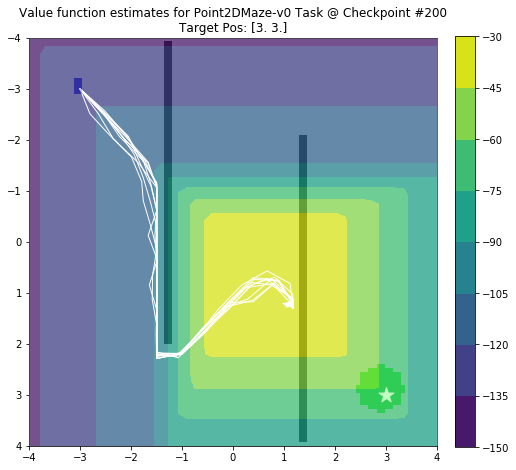

In [398]:
plt.figure(figsize=(8, 8))
from matplotlib.patches import Rectangle
# plt.gca().invert_yaxis()

plt.imshow(train_env.render('rgb_array', width=32, height=32),
           extent=(-4, 4, -4, 4), origin='lower', alpha=0.25, zorder=3)
plt.gca().invert_yaxis()
plt.contourf(xys[0], xys[1], np.array(value_estimates).reshape(xys[0].shape))
plt.colorbar(fraction=0.046, pad=0.04)

plot_trajectories(checkpoint, checkpoint_dir)

if task == 'BoxWall-v1':
    currentAxis = plt.gca()
    currentAxis.add_patch(Rectangle((-2, -2), 4, 4,
                          alpha=1, fill=None, linewidth=4))

plt.scatter(*target_pos, marker='*', s=250, color='white')
plt.title(f'Value function estimates for {domain + task} Task @ Checkpoint #{checkpoint_to_analyze}\n'
          + f'Target Pos: {target_pos}')
plt.show()

In [ ]:
Qs[0].summary()

In [ ]:
np.repeat(grid_vals[0], n_action_samples).reshape((n_action_samples, -1))